Guglielmo Biagini

guglielmo.biagini@studio.unibo.it

ID number:0001092693

# Next frame prediction

The project consists of predicting the next frame in a short movie sequence.

For this project, we shall use the Moving MNIST dataset, composed of 10,000 video sequences, each consisting of 20 frames. In each video sequence, two digits move independently around the frame, which has a spatial resolution of 64×64 pixels. The digits frequently intersect with each other and bounce off the edges of the frame.

While each sequence has a lenght of 20, your are supposed to use **only 3 consecutive frames as input**, and **predict the next one**.

The metric used to evalaute the quality of the predicted frame is Mean Squared Error.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from keras.api._v2.keras import callbacks

In [ ]:
ds = tfds.as_numpy(tfds.load(
    'moving_mnist',
    split='test',
    batch_size=-1
))
sequences = ds['image_sequence']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/moving_mnist/1.0.0.incompleteINNDOM/moving_mnist-test.tfrecord*...:   0%| …

Dataset moving_mnist downloaded and prepared to /root/tensorflow_datasets/moving_mnist/1.0.0. Subsequent calls will reuse this data.


The dataset is composed of 10000 sequences of 20 frames each. Each (grayscale) frame has dimnesion 64x64

In [ ]:
sequences = ds['image_sequence']
sequences = sequences/255.    #normalize the data
print(sequences.shape)
print(np.min(sequences),np.max(sequences))

(10000, 20, 64, 64, 1)
0.0 1.0


Let us split the dataset in training, validation and testing.
You are supposed to evaluate the performance of your model using MSE over the full test set.

In [ ]:
trainset = sequences[:8000]
valset = sequences[8000:9000]
testset = sequences[9000:10000]

Here is a simple generator, creating the input sequences of 3 frames, and the expected output, namely the next frame.

In [ ]:
def image_generator(dataset,batchsize=16,seqlen=4):
    while True:
      batch_x = np.zeros((batchsize,seqlen-1,64,64,1))
      batch_y = np.zeros((batchsize,1,64,64,1))
      ran = np.random.randint(dataset.shape[0],size=batchsize)
      minibatch = dataset[ran]
      #these sequences have length 20; we reduce them to seqlen
      for i in range(batchsize):
          random_start = np.random.randint(0,20-seqlen)
          random_end = random_start+seqlen-1
          batch_x[i] = minibatch[i,random_start:random_end,:,:,:]
          batch_y[i] = minibatch[i,random_end:random_end+1:,:,:]
          #print(batch_x.shape,batch_y.shape)
          #print(batch_x.min(),batch_x.max())
          #print(batch_x.min(),batch_x.max())
      yield(batch_x,batch_y)

In [ ]:
def show_list(images): #takes in input a list of images and plot them
    size = len(images)
    plt.figure(figsize=(10, 10 * size))
    for i in range(size):
        plt.subplot(1, size, i + 1)
        plt.title('Frame '+str(i))
        plt.imshow(images[i],cmap='gray',)

    plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

###Create the generator


In [ ]:
train_gen = image_generator(trainset)
val_gen = image_generator(valset)
test_gen = image_generator(testset)

## Create the Convolutional-LSTM model

The lines of code below define the convolutional base using a common pattern: a stack of [ConvLSTM2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ConvLSTM2D) and [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) layers.


*  The ConvLSTM2D layer takes as input, if data_format='channels_first'
(default), a 5D tensor with shape (samples, time, channels, rows, cols) or,  if data_format='channels_last', a 5D tensor with shape (samples, time, rows, cols, channels).

 A ConvLSTM2D extends the traditional LSTM by introducing convolutional operations on the input data, enabling it to learn spatio-temporal patterns in sequential data.
 ConvLSTM networks benefit from parameter sharing across both spatial and temporal dimensions. The convolutional layers share weights across the spatial dimensions of each frame, allowing the network to generalize well and capture spatial patterns regardless of their location within the frame. The recurrent connections share weights across the temporal dimension, enabling the network to exploit temporal regularities and generalize to sequences of varying lengths.



 * Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.



 After the stack a conv3d layer is added, used to compress data. In this layer a sigmoid activation function is used because in ouput we want an image with values between 0 and 1 (normalized).

 Finally we want to have as output only the last frame. In fact, as any RNN, the output of a ConvLSTM is a sequence over time (one output for each input), so the better result will be the one corresponding to the last step.

In [ ]:
def get_model(Input_shape):

  input = layers.Input(shape=Input_shape)

  c1 = layers.ConvLSTM2D(
      filters=64,
      kernel_size=(5, 5),
      padding="same",
      return_sequences=True,
      activation="relu",
  )(input)

  b1 = layers.BatchNormalization()(c1)   #used to stabilize training

  c2 = layers.ConvLSTM2D(
      filters=64,
      kernel_size=(5, 5),
      padding="same",
      return_sequences=True,
      activation="relu",
  )(b1)

  b2 = layers.BatchNormalization()(c2)  #used to stabilize training

  c3 = layers.ConvLSTM2D(
      filters=64,
      kernel_size=(5, 5),
      padding="same",
      return_sequences=True,
      activation="relu",
  )(b2)

  b3 = layers.BatchNormalization()(c3)    #used to stabilize training

  c4 = layers.ConvLSTM2D(
      filters=32,
      kernel_size=(5, 5),
      padding="same",
      return_sequences=True,
      activation="relu",
  )(b3)

  conv1 = layers.Conv3D(
      filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
  )(c4)

  #to get as output only the last frame
  separate_frame = layers.Lambda(lambda x: x[:,-1, :, :, :])(conv1)
  reshaped = layers.Reshape((1,64,64,1))(separate_frame)


  model = keras.models.Model(input, reshaped)
  #compile the model
  model.compile(
    loss=keras.losses.binary_crossentropy,metrics=tf.keras.metrics.mean_squared_error, optimizer=keras.optimizers.Adam(),
  )
  model.summary()
  return model

### Get the model and print the summary






In [ ]:
model=get_model(Input_shape=(None,64,64,1))  #as input we can give a variable sequence of 64x64x1 frames

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 64, 64, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 64, 64, 64)  416256    
                                                                 
 batch_normalization (BatchN  (None, None, 64, 64, 64)  256      
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 64, 64, 64)  819456    
                                                                 
 batch_normalization_1 (Batc  (None, None, 64, 64, 64)  256      
 hNormalization)                                                 
                                                             

###Train the model

To train the model a callback is added in order to avoid overfitting. In particular the loss function on the validation set is monitored, if it stops improving the training is interrupted and the best result are restored (setting the parameter 'restore_best_weights=true').

In [ ]:
# Define some callbacks to improve training, avoiding overfitting
callback = keras.callbacks.EarlyStopping(monitor="val_loss",
    mode = "min",
    patience=10,
    restore_best_weights=True)
#set the number of steps
#we use (number of samples)//batchsize
train_steps=len(trainset)//16
val_steps=len(valset)//16

#in model.fit we do not have to specify the batch size since we are using generators
history=model.fit(x=train_gen,
                    validation_data=val_gen,steps_per_epoch=train_steps,validation_steps=val_steps,callbacks=[callback],
                    epochs=25)  #verbose??

Epoch 1/25
500/500 [==============================] - 325s 605ms/step - loss: 0.0781 - mean_squared_error: 0.0184 - val_loss: 0.3845 - val_mean_squared_error: 0.0394
Epoch 2/25
500/500 [==============================] - 303s 605ms/step - loss: 0.0653 - mean_squared_error: 0.0140 - val_loss: 0.0661 - val_mean_squared_error: 0.0141
Epoch 3/25
500/500 [==============================] - 303s 605ms/step - loss: 0.0623 - mean_squared_error: 0.0129 - val_loss: 0.0620 - val_mean_squared_error: 0.0129
Epoch 4/25
500/500 [==============================] - 303s 606ms/step - loss: 0.0608 - mean_squared_error: 0.0124 - val_loss: 0.0611 - val_mean_squared_error: 0.0126
Epoch 5/25
500/500 [==============================] - 303s 605ms/step - loss: 0.0593 - mean_squared_error: 0.0119 - val_loss: 0.0705 - val_mean_squared_error: 0.0157
Epoch 6/25
500/500 [==============================] - 302s 605ms/step - loss: 0.0587 - mean_squared_error: 0.0116 - val_loss: 0.0622 - val_mean_squared_error: 0.0128
Epoc

From the 17-th epoch the MSE decreases very slowly, so we could also consider to reduce the number of epoch to speed up the training.

###Result Inspection

In [ ]:
#Function to display the loss and the mse values during the training
def display_history(history):
    mse_training = history.history['loss']
    acc_training = history.history['mean_squared_error']

    mse_val = history.history['val_loss']
    acc_val = history.history['val_mean_squared_error']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # and of the MSE
    plt.plot(acc_training)
    plt.plot(acc_val)
    plt.grid()
    plt.title('MSE during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

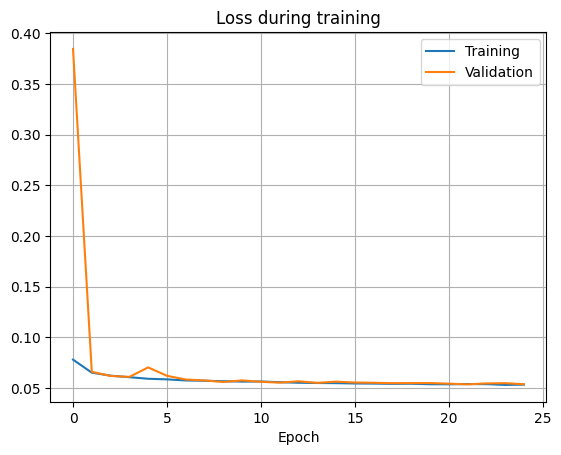

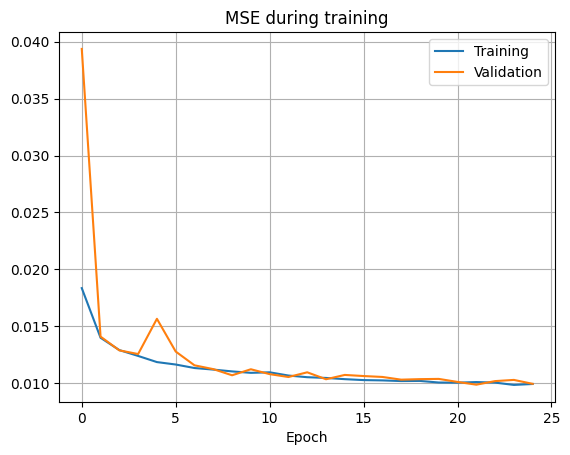

In [ ]:
display_history(history)

From the two plots we can see that both loss and MSE decrease increasing the number of epoch.
The results on the validation set are a little bit unstable, but at the end we cannot talk of overfitting.

#Test the model on the test samples

In [ ]:
model.evaluate(x=test_gen,steps=len(testset)//16)

62/62 [==============================] - 14s 217ms/step - loss: 0.0533 - mean_squared_error: 0.0099


[0.053337182849645615, 0.009878277778625488]

Also on the test set the model has good results.

##Predicted Frame Visualization

First, create a new generator that returns 4 frame of a single video taken from the test set.

In [ ]:
#First, create a new generator that returns 4 frame of a single video
gen = image_generator(testset,batchsize=1,seqlen=4)
sample_x, sample_y = next(gen)
new_prediction = model.predict(sample_x)

1/1 [==============================] - 0s 26ms/step


Then, show the comparison between the ground truth and the model prediction.

The first three frames are the same in both plots.
The fouth frame is what we want to predict, so in the first plot there will be the real image, meanwhile in the second we will show the predicted one.


GROUND TRUTH



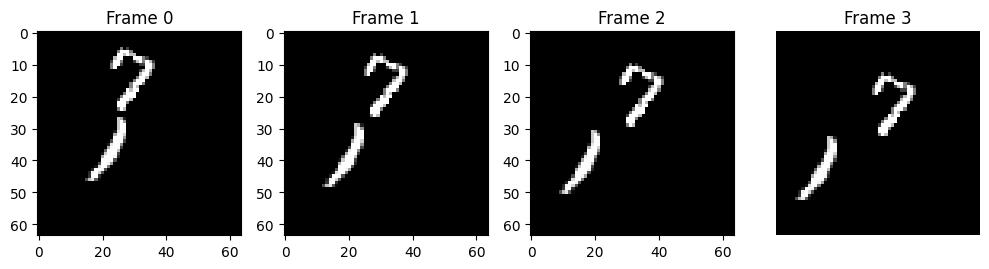


PREDICTION



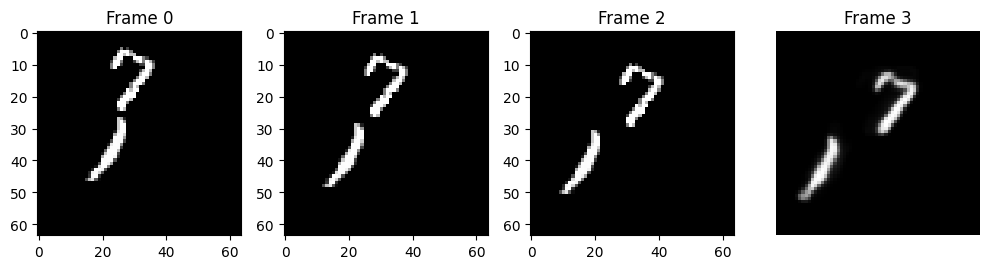

In [ ]:

#show

all = [sample_x[0,i,:,:,0] for i in range(3)]+[sample_y[0,0,:,:,0]]
print('GROUND TRUTH\n')
show_list(all)

print('\nPREDICTION\n')
all = [sample_x[0,i,:,:,0] for i in range(3)]+[new_prediction[0,-1,:,:,0]]
show_list(all)

# Conclusions:
The results show that in a small number of epoch the model is able to predict, given three frame as input, the following frame in a reasonable way. In fact a low MSE is achieved on the test set and, as we can see from the previous plots, the visual prediction of the model is very similar to the ground truth.
Furthermore, from the train history, we can assume that (slightly) better results could be achieved increasing the number of epoch and using callbacks to avoid overfitting.
Finally we can say that the combination of convolutional and recurrent operations in CONVLSTM networks makes them powerful for next frame prediction tasks, allowing them to effectively capture both spatial and temporal dependencies in sequential data.


# Bibliography
**[[1]](https://keras.io/examples/vision/conv_lstm/)** 'Next-frame prediction with convLSTMs'

**[[2]](https://arxiv.org/pdf/1506.04214v1.pdf)** 'Convolutional LSTM Network: A Machine Learning
Approach for Precipitation Nowcasting'. Xingjian Shi - Zhourong Chen - Hao Wang - Dit-Yan Yeung

**[[3]](https://www.kaggle.com/code/kcostya/convlstm-convolutional-lstm-network-tutorial)** ConvLSTM: Convolutional LSTM Network Tutorial

